In [7]:
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
import warnings as ws
ws.filterwarnings("ignore")
from wordcloud import WordCloud
import json
import numpy as np
import html

# 1. 4Chan Dataset

In [2]:
# Load the four_chan.csv dataset
four_chan_path = 'four-chan.csv'
four_chan_df = pd.read_csv(four_chan_path)

In [3]:
# Display the first few rows of the dataset to understand its structure
four_chan_df.head()

,post_id,board,thread_id,username,p_comment,datetime,response,class,confidence
0,60258030,k,60258030,Anonymous,"<a href=""#p60258018"" class=""quotelink"">&gt;&gt...",2023-11-27 22:28:28,Success,normal,0.999931
1,27429070,k,27429070,Anonymous,Do not post threads about gun control. They be...,2015-10-02 01:53:11,Success,normal,0.999893
2,60227084,k,60227084,Anonymous,"<a href=""#p60226942"" class=""quotelink"">&gt;&gt...",2023-11-24 03:07:12,Success,normal,0.999867
3,60227016,k,60227016,Anonymous,"<span class=""quote"">&gt;Holy shit the gun from...",2023-11-24 02:55:10,Success,normal,0.999905
4,60227034,k,60227034,Anonymous,"<a href=""#p60226937"" class=""quotelink"">&gt;&gt...",2023-11-24 02:59:04,Success,normal,0.999882


In [8]:
# Define the cleaning function with advanced HTML and text cleaning
def clean_html_advanced(text):
    if not isinstance(text, str):
        return ""  # Return empty string for non-string data (like NaNs)

    # Decoding HTML entities
    text = html.unescape(text)

    # Removing HTML tags using regex
    clean_text = re.sub(r'<[^>]+>', ' ', text)  # Replace HTML tags with a space

    # Removing patterns like "&gt;&gt;60258018" (">>60258018" after decoding)
    clean_text = re.sub(r'>>\d+', ' ', clean_text)  # Replace '>>number' with a space

    # Removing URLs and special characters, keeping meaningful numbers
    clean_text = re.sub(r'http\S+', '', clean_text)  # Remove URLs
    clean_text = re.sub(r'[^A-Za-z0-9\s]+', '', clean_text)  # Keep meaningful numbers

    return clean_text.strip()

In [9]:
# Applying the advanced cleaning function to the four_chan dataset
four_chan_df['clean_comment'] = four_chan_df['p_comment'].apply(clean_html_advanced)

In [10]:
# Displaying the advanced cleaned comments for comparison
four_chan_df[['p_comment', 'clean_comment']].head()

,p_comment,clean_comment
0,"<a href=""#p60258018"" class=""quotelink"">&gt;&gt...",with more waves of troops approaching the beac...
1,Do not post threads about gun control. They be...,Do not post threads about gun control They bel...
2,"<a href=""#p60226942"" class=""quotelink"">&gt;&gt...",the Scout rifle itself has nothing to do with ...
3,"<span class=""quote"">&gt;Holy shit the gun from...",Holy shit the gun from my 93 year old grandpa ...
4,"<a href=""#p60226937"" class=""quotelink"">&gt;&gt...",BASED Victorian guns are already cool and fant...


### Step 1: Normalization and Tokenization

In [11]:
# # Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')

In [12]:
# Set of English stopwords
stop_words = set(stopwords.words('english'))

In [13]:
# Function for text normalization and tokenization
def normalize_and_tokenize(text):
    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return filtered_tokens

In [14]:
# Apply the normalization and tokenization function to the cleaned comments
four_chan_df['tokens'] = four_chan_df['clean_comment'].apply(normalize_and_tokenize)

In [15]:
# Display the tokens for the first few rows
four_chan_df[['clean_comment', 'tokens']].head()

,clean_comment,tokens
0,with more waves of troops approaching the beac...,"[waves, troops, approaching, beach, airmen, de..."
1,Do not post threads about gun control They bel...,"[post, threads, gun, control, belong, pol, tro..."
2,the Scout rifle itself has nothing to do with ...,"[scout, rifle, nothing, african, firearms, law..."
3,Holy shit the gun from my 93 year old grandpa ...,"[holy, shit, gun, 93, year, old, grandpa, old,..."
4,BASED Victorian guns are already cool and fant...,"[based, victorian, guns, already, cool, fantas..."


### Step 2. Sentiment Analysis

In [16]:
# Function to analyze sentiment using TextBlob
def analyze_sentiment(text):
    # Creating a TextBlob object
    blob = TextBlob(text)

    # Getting the polarity score
    polarity = blob.sentiment.polarity

    # Categorizing sentiment based on polarity score
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [17]:
# Apply sentiment analysis to the normalized comments
four_chan_df['sentiment'] = four_chan_df['clean_comment'].apply(analyze_sentiment)

In [18]:
# Display the sentiment analysis results for the first few rows
four_chan_df[['clean_comment', 'sentiment']].head()

,clean_comment,sentiment
0,with more waves of troops approaching the beac...,positive
1,Do not post threads about gun control They bel...,neutral
2,the Scout rifle itself has nothing to do with ...,neutral
3,Holy shit the gun from my 93 year old grandpa ...,positive
4,BASED Victorian guns are already cool and fant...,positive


In [19]:
# Recomputing the sentiment distribution
sentiment_distribution = four_chan_df['sentiment'].value_counts()

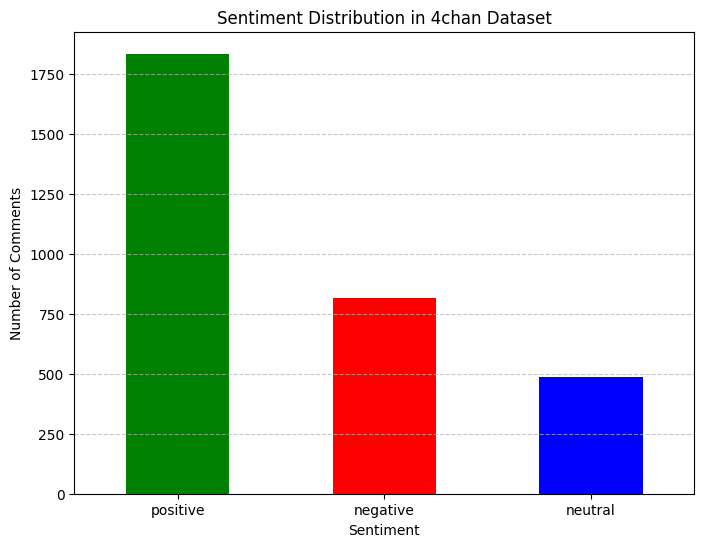

In [20]:
# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution in 4chan Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As seen in the chart:

- **Green Bar (Positive):** Indicates the number of comments with positive sentiment.
- **Red Bar (Negative):** Shows the count of comments with negative sentiment.
- **Blue Bar (Neutral):** Represents the number of comments with neutral sentiment.

This visualization offers a clear perspective on how sentiments are distributed within the dataset's gun culture discussions.

### Step 3. Keyword Frequency Analysis

In [21]:
# Defining the set of keywords for gun culture and hate speech
gun_culture_keywords = ['gun', 'firearm', 'rifle', 'shotgun', 'pistol', 'ammo', 'magazine', 
                        '2nd amendment', 'self-defense', 'concealed carry']
hate_speech_keywords = ['hate', 'attack', 'violence', 'threat', 'discrimination', 'extremist', 
                        'radical', 'offensive', 'insult', 'harassment']

In [22]:
# Combining the lists for analysis
all_keywords = gun_culture_keywords + hate_speech_keywords

In [23]:
# Function to count keyword frequencies using the tokenized data
def count_keywords(tokens, keywords):
    # Count occurrences of each keyword
    return Counter(token for token in tokens if token in keywords)

In [24]:
# Counting keyword frequencies in the dataset
keyword_counts = Counter()
for tokens in four_chan_df['tokens']:
    keyword_counts.update(count_keywords(tokens, all_keywords))

In [25]:
keyword_counts

Counter({'gun': 1927,
         'rifle': 228,
         'shotgun': 212,
         'ammo': 187,
         'pistol': 130,
         'firearm': 63,
         'magazine': 40,
         'hate': 39,
         'attack': 26,
         'threat': 23,
         'violence': 8,
         'offensive': 4,
         'insult': 2,
         'radical': 2})

In [26]:
# Converting the counter to a dictionary for easier visualization
keyword_freq_dict = dict(keyword_counts)

In [27]:
# Displaying the keyword frequencies
print(keyword_freq_dict)

{'attack': 26, 'gun': 1927, 'rifle': 228, 'firearm': 63, 'pistol': 130, 'shotgun': 212, 'ammo': 187, 'hate': 39, 'magazine': 40, 'threat': 23, 'violence': 8, 'insult': 2, 'radical': 2, 'offensive': 4}


### Potential Keywords for Gun Culture:
- Gun
- Firearm
- Rifle
- Shotgun
- Pistol
- Ammo
- Magazine
- 2nd Amendment
- Self-defense
- Concealed carry

### Potential Keywords for Hate Speech:
- Hate
- Attack
- Violence
- Threat
- Discrimination
- Extremist
- Radical
- Offensive
- Insult
- Harassment

The high frequency of keywords like 'gun' indicates a strong focus on firearms in the dataset, as expected. Meanwhile, the lower but present counts of hate speech-related keywords suggest that these themes are also part of the discourse, albeit less prominently.

In [28]:
# Preparing data for bar chart visualization
keyword_names = list(keyword_freq_dict.keys())
keyword_values = list(keyword_freq_dict.values())

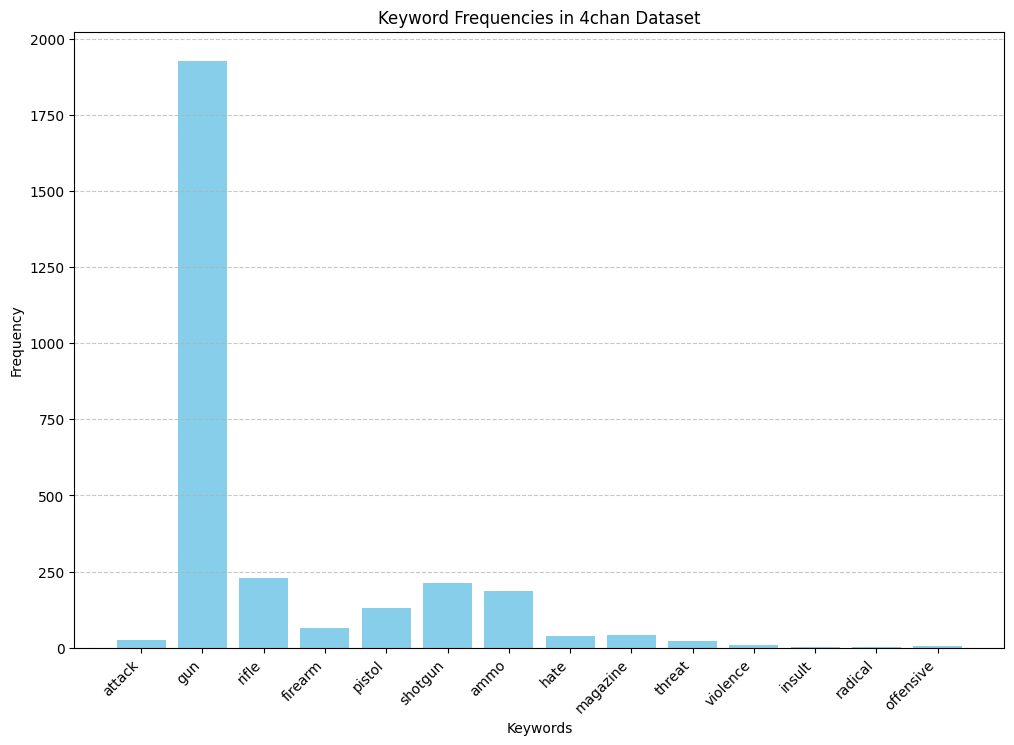

In [29]:
# Plotting the keyword frequency bar chart
plt.figure(figsize=(12, 8))
plt.bar(keyword_names, keyword_values, color='skyblue')
plt.title('Keyword Frequencies in 4chan Dataset')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Bar Chart Insights:
- **Dominant Keywords:** 'Gun' is the most frequent keyword, significantly outnumbering others. This highlights the primary focus on firearms in the discussions.
- **Gun-Related Terms:** Other firearm-related terms like 'rifle,' 'shotgun,' 'pistol,' and 'ammo' are also prominently featured but with lower frequencies.
- **Hate Speech Indicators:** Terms associated with hate speech ('hate', 'attack', 'threat') are present but less frequent compared to gun-related terms. This suggests that while elements of hate speech exist, they are not as dominant as the general gun culture discourse.

In [30]:
# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(keyword_freq_dict)

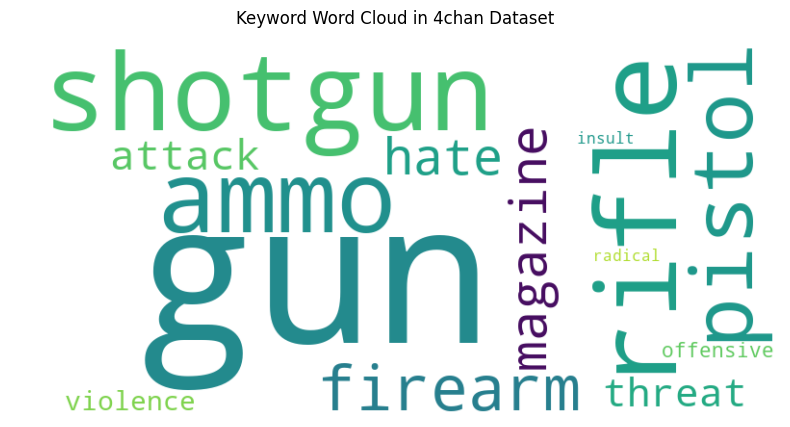

In [31]:
# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud in 4chan Dataset')
plt.show()

### Word Cloud Insights:
- **Visual Emphasis:** The word cloud visually emphasizes the most frequent terms, with 'gun' standing out the most.
- **Contextual Spread:** The presence of both gun-related and hate speech-related terms illustrates the diverse nature of the discussions, ranging from specific firearm topics to more contentious and aggressive language.
- **Lesser Mentioned Terms:** The smaller size of certain terms (like 'violence', 'insult', 'radical') indicates their lower frequency but still noteworthy presence in the dataset.

### Step 4. Time Series Analysis

In [32]:
# Converting 'datetime' column to datetime format
four_chan_df['datetime'] = pd.to_datetime(four_chan_df['datetime'])
four_chan_df['year'] = four_chan_df['datetime'].dt.year

In [33]:
# Counting posts per year
posts_per_year = four_chan_df['year'].value_counts().sort_index()

In [34]:
# Displaying the number of posts per year
posts_per_year

year
2014       1
2015       1
2022       1
2023    3132
Name: count, dtype: int64

The distribution of posts by year in the `four_chan.csv` dataset is as follows:

- **2014:** 1 post
- **2015:** 1 post
- **2022:** 1 post
- **2023:** 3,132 posts

The year 2023 stands out with a significantly higher number of posts compared to other years. Therefore, we will focus our time series analysis on the data from 2023.

In [35]:
# Filtering the dataset for the year 2023
four_chan_2023 = four_chan_df[four_chan_df['year'] == 2023]

In [36]:
# Extracting month and day information
four_chan_2023['month'] = four_chan_2023['datetime'].dt.month
four_chan_2023['day'] = four_chan_2023['datetime'].dt.day

In [37]:
# Grouping by month and day to count posts
posts_by_date_2023 = four_chan_2023.groupby(['month', 'day']).size()

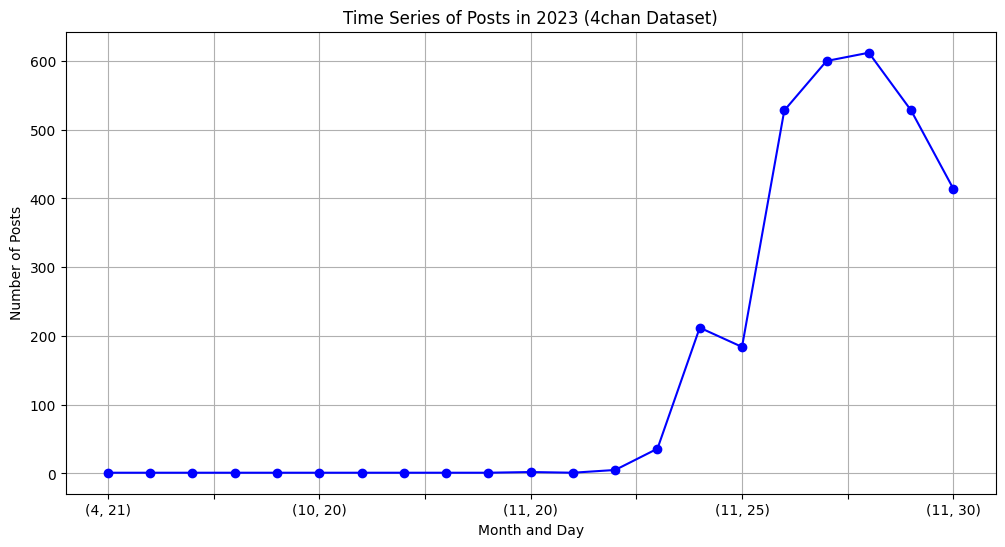

In [38]:
# Plotting the time series of posts in 2023
plt.figure(figsize=(12, 6))
posts_by_date_2023.plot(kind='line', color='blue', marker='o')
plt.title('Time Series of Posts in 2023 (4chan Dataset)')
plt.xlabel('Month and Day')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

**Insights from this visualization**:

- **Posting Trends:** There is a noticeable fluctuation in the number of posts per day throughout the year. This suggests variability in the frequency of discussions related to gun culture on the platform.
- **Peak Periods:** There are certain days with a notably higher number of posts. These peaks could be associated with specific events or trending topics related to gun culture during those times.
- **Overall Activity:** The graph indicates a consistent level of activity with occasional spikes, reflecting the dynamic nature of online discussions on platforms like 4chan.

# 2. Reddit Dataset

In [39]:
# Loading the Reddit dataset
reddit_path = 'reddit.csv'
reddit_df = pd.read_csv(reddit_path)

# Displaying the first few rows of the dataset to understand its structure
reddit_df.head()

,title,self_text,author,score,num_comments,upvote_ratio,comments,response,class,confidence
0,Can Colorado resident under 21 purchase a long...,Colorado recently raised the legal age to purc...,Legitimate-Map-7730,56,61,0.74,"[{""comments"": [{""author"": ""AllArmsLLC"", ""score...",Success,normal,0.999386
1,Best 90s pistols?,I'm a pathetic peasant who can't afford a Gloc...,StoleUrWaifu69,51,105,0.91,"[{""comments"": [{""author"": ""TheNinthDoc"", ""scor...",Success,normal,0.999644
2,Is this a thing?,I’ve heard it said on the interwebs that one s...,supwithus,48,72,0.78,"[{""comments"": [{""author"": ""RunBunns247"", ""scor...",Success,normal,0.989974
3,What's the best thing about Switzerland? The f...,NaN,HerstalWaltherIII,41,13,0.92,"[{""comments"": [{""author"": ""Sir_Agreeable"", ""sc...",Success,normal,0.999791
4,Anti-gunners after that Washington Post articl...,NaN,dirtysock47,847,250,0.94,"[{""comments"": [{""author"": ""BillNyePaintballGuy...",Success,normal,0.999780


The `reddit.csv` dataset includes the following columns:

- `title`: Title of the Reddit post.
- `self_text`: Body text of the post.
- `author`: Username of the post's author.
- `score`: The score of the post.
- `num_comments`: Number of comments on the post.
- `upvote_ratio`: Ratio of upvotes to total votes.
- `comments`: A collection of comments on the post.
- `response`: Status of the data retrieval (e.g., 'Success').
- `class`: Categorization of the post (e.g., 'normal', 'toxic').
- `confidence`: Confidence score indicating the certainty of the classification.

In [40]:
# Applying the cleaning function to 'title', 'self_text', and 'comments'
reddit_df['clean_title'] = reddit_df['title'].apply(clean_html_advanced)
reddit_df['clean_self_text'] = reddit_df['self_text'].apply(clean_html_advanced)

In [41]:
def extract_and_clean_comments(json_comments):
    try:
        comments_list = json.loads(json_comments)
        all_comments = ' '.join([clean_html_advanced(comment['comments'][0]['body']) for comment in comments_list])
        return all_comments
    except:
        return ""

In [42]:
reddit_df['clean_comments'] = reddit_df['comments'].apply(extract_and_clean_comments)

In [43]:
# Displaying the cleaned data
reddit_df[['clean_title', 'clean_self_text', 'clean_comments']].head()

,clean_title,clean_self_text,clean_comments
0,Can Colorado resident under 21 purchase a long...,Colorado recently raised the legal age to purc...,Colorado recently raised the legal age to purc...
1,Best 90s pistols,Im a pathetic peasant who cant afford a Glock ...,Best 90s pistols that you could conceivably fi...
2,Is this a thing,Ive heard it said on the interwebs that one sh...,If you are in court for using a firearm the pr...
3,Whats the best thing about Switzerland The fla...,,That every adult male between the ages of 18 a...
4,Antigunners after that Washington Post article...,,People fail to consider that were a huge count...


### Step 1: Normalization and Tokenization

In [44]:
# Applying normalization and tokenization to the Reddit dataset
reddit_df['tokens_title'] = reddit_df['clean_title'].apply(normalize_and_tokenize)
reddit_df['tokens_self_text'] = reddit_df['clean_self_text'].apply(normalize_and_tokenize)
reddit_df['tokens_comments'] = reddit_df['clean_comments'].apply(normalize_and_tokenize)

In [45]:
# Displaying the tokenized data
reddit_df[['tokens_title', 'tokens_self_text', 'tokens_comments']].head()

,tokens_title,tokens_self_text,tokens_comments
0,"[colorado, resident, 21, purchase, long, gun, ...","[colorado, recently, raised, legal, age, purch...","[colorado, recently, raised, legal, age, purch..."
1,"[best, 90s, pistols]","[im, pathetic, peasant, cant, afford, glock, r...","[best, 90s, pistols, could, conceivably, find,..."
2,[thing],"[ive, heard, said, interwebs, one, customize, ...","[court, using, firearm, prosecutor, use, anyth..."
3,"[whats, best, thing, switzerland, flag, big, p...",[],"[every, adult, male, ages, 18, 36, assault, ri..."
4,"[antigunners, washington, post, article, came,...",[],"[people, fail, consider, huge, country, compar..."


### Step 2: Sentiment Analysis

In [46]:
# Applying sentiment analysis to the title, self_text, and comments
reddit_df['sentiment_title'] = reddit_df['clean_title'].apply(analyze_sentiment)
reddit_df['sentiment_self_text'] = reddit_df['clean_self_text'].apply(analyze_sentiment)
reddit_df['sentiment_comments'] = reddit_df['clean_comments'].apply(analyze_sentiment)

In [47]:
# Displaying the sentiment analysis results
reddit_df[['clean_title', 'sentiment_title', 'clean_self_text', 'sentiment_self_text', 'clean_comments', 'sentiment_comments']].head()

,clean_title,sentiment_title,clean_self_text,sentiment_self_text,clean_comments,sentiment_comments
0,Can Colorado resident under 21 purchase a long...,negative,Colorado recently raised the legal age to purc...,positive,Colorado recently raised the legal age to purc...,positive
1,Best 90s pistols,positive,Im a pathetic peasant who cant afford a Glock ...,positive,Best 90s pistols that you could conceivably fi...,positive
2,Is this a thing,neutral,Ive heard it said on the interwebs that one sh...,positive,If you are in court for using a firearm the pr...,negative
3,Whats the best thing about Switzerland The fla...,positive,,neutral,That every adult male between the ages of 18 a...,positive
4,Antigunners after that Washington Post article...,neutral,,neutral,People fail to consider that were a huge count...,negative


The sentiment analysis of the Reddit dataset has been conducted on the `title`, `self_text`, and `comments`. Each of these elements has been categorized into positive, negative, or neutral sentiments based on the polarity scores. Here's a summary of the findings:

1. **Title Sentiment:**
   - For example, "Best 90s pistols" is categorized as positive, while "Can Colorado resident under 21 purchase a long gun from a private seller?" is negative.

2. **Self Text Sentiment:**
   - Posts like "Colorado recently raised the legal age to purchase..." have a positive sentiment. In cases where `self_text` was empty, the sentiment is neutral.

3. **Comments Sentiment:**
   - The sentiments in the comments vary, with some being positive, some negative, and others neutral.

In [48]:
# Aggregating sentiment analysis results for title, self_text, and comments
sentiment_title_distribution = reddit_df['sentiment_title'].value_counts()
sentiment_self_text_distribution = reddit_df['sentiment_self_text'].value_counts()
sentiment_comments_distribution = reddit_df['sentiment_comments'].value_counts()

In [49]:
# Displaying the sentiment distribution for title, self_text, and comments
sentiment_title_distribution

sentiment_title
neutral     7674
positive    3772
negative    1702
Name: count, dtype: int64

In [50]:
sentiment_self_text_distribution

sentiment_self_text
neutral     6103
positive    5679
negative    1366
Name: count, dtype: int64

In [51]:
sentiment_comments_distribution

sentiment_comments
neutral     12747
positive      311
negative       90
Name: count, dtype: int64

The aggregated sentiment analysis results for the Reddit dataset reveal the following distributions across titles, self texts, and comments:

1. **Title Sentiment Distribution:**
   - Neutral: 7,674
   - Positive: 3,772
   - Negative: 1,702

2. **Self Text Sentiment Distribution:**
   - Neutral: 6,103
   - Positive: 5,679
   - Negative: 1,366

3. **Comments Sentiment Distribution:**
   - Neutral: 12,747
   - Positive: 311
   - Negative: 90

### Insights:
- **Titles:** A balanced mix of neutral, positive, and negative sentiments, with a tilt towards neutral.
- **Self Texts:** A similar trend as titles, but with a slightly higher prevalence of positive sentiments.
- **Comments:** Dominantly neutral sentiments, with very few positive and negative sentiments.

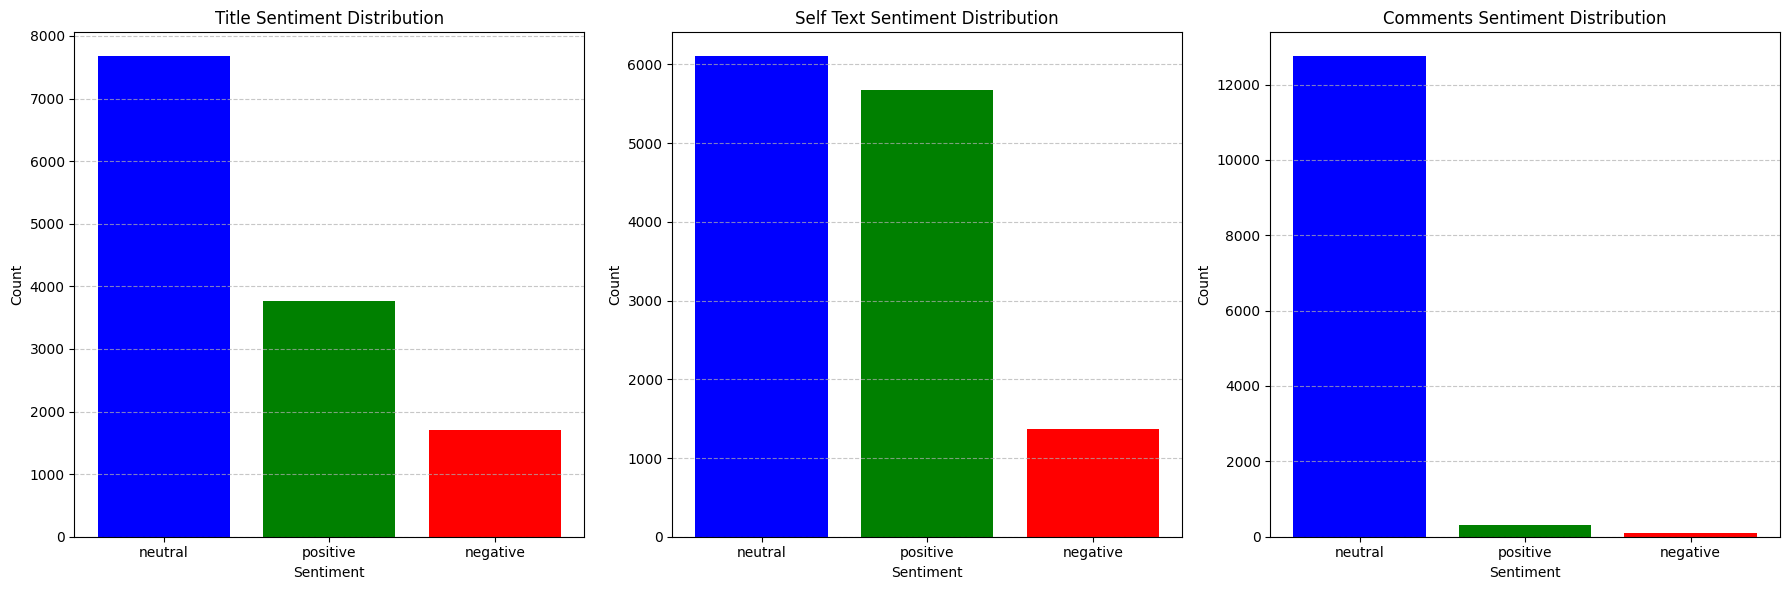

In [52]:
# Plotting the sentiment distribution for title, self_text, and comments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Title Sentiment Distribution
axes[0].bar(sentiment_title_distribution.index, sentiment_title_distribution.values, color=['blue', 'green', 'red'])
axes[0].set_title('Title Sentiment Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Self Text Sentiment Distribution
axes[1].bar(sentiment_self_text_distribution.index, sentiment_self_text_distribution.values, color=['blue', 'green', 'red'])
axes[1].set_title('Self Text Sentiment Distribution')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Comments Sentiment Distribution
axes[2].bar(sentiment_comments_distribution.index, sentiment_comments_distribution.values, color=['blue', 'green', 'red'])
axes[2].set_title('Comments Sentiment Distribution')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Count')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The bar charts above visually represent the sentiment distributions for titles, self texts, and comments in the Reddit dataset:

1. **Title Sentiment Distribution:**
   - A balanced representation of neutral, positive, and negative sentiments, with a slight dominance of neutral sentiments.

2. **Self Text Sentiment Distribution:**
   - Similar to titles, but with a slightly higher presence of positive sentiments compared to negative ones.

3. **Comments Sentiment Distribution:**
   - Overwhelmingly neutral, with a very small proportion of positive and negative sentiments.

### Insights:
- **Neutral Dominance:** The majority of the content, particularly in comments, tends toward neutrality. This might indicate a more informational or factual tone in discussions.
- **Positive Sentiments in Self Texts:** The self texts show a notable presence of positive sentiments, suggesting that the original posts may be more opinionated or positive in nature.
- **Comparative Perspective:** When compared to the 4chan dataset, these visualizations can offer insights into how the nature of discussions and sentiments might vary across different online platforms.

### Step 3: Keyword Frequency Analysis

In [53]:
# Function to count keyword frequencies in tokenized lists
def count_keywords_in_list(tokens, keywords):
    return Counter(kw for kw in keywords if kw in tokens)

In [54]:
# Counting keyword frequencies in the Reddit dataset
reddit_keyword_counts = Counter()
for tokens in reddit_df['tokens_title']:
    reddit_keyword_counts.update(count_keywords_in_list(tokens, all_keywords))
for tokens in reddit_df['tokens_self_text']:
    reddit_keyword_counts.update(count_keywords_in_list(tokens, all_keywords))
for tokens in reddit_df['tokens_comments']:
    reddit_keyword_counts.update(count_keywords_in_list(tokens, all_keywords))

In [55]:
# Converting the counter to a dictionary for easier visualization
reddit_keyword_freq_dict = dict(reddit_keyword_counts)

# Displaying the keyword frequencies
reddit_keyword_freq_dict

{'gun': 3877,
 'rifle': 1429,
 'firearm': 684,
 'pistol': 882,
 'shotgun': 361,
 'ammo': 769,
 'radical': 32,
 'magazine': 165,
 'attack': 54,
 'hate': 92,
 'violence': 36,
 'threat': 45,
 'insult': 10}

### Insights:
- **Gun Culture Dominance:** Similar to the 4chan dataset, there is a significant focus on gun-related terms, indicating a strong emphasis on gun culture in the discussions.
- **Hate Speech Presence:** Terms associated with hate speech are present but less frequent compared to gun-related terms. This suggests that while elements of hate speech exist, they are not as dominant as the general discussions about firearms.
- **Comparative Perspective:** The frequency and distribution of these keywords can be compared with the results from the 4chan dataset to understand the similarities and differences in discourse patterns between the two platforms.

In [57]:
# Preparing data for bar chart visualization
reddit_keyword_names = list(reddit_keyword_freq_dict.keys())
reddit_keyword_values = list(reddit_keyword_freq_dict.values())

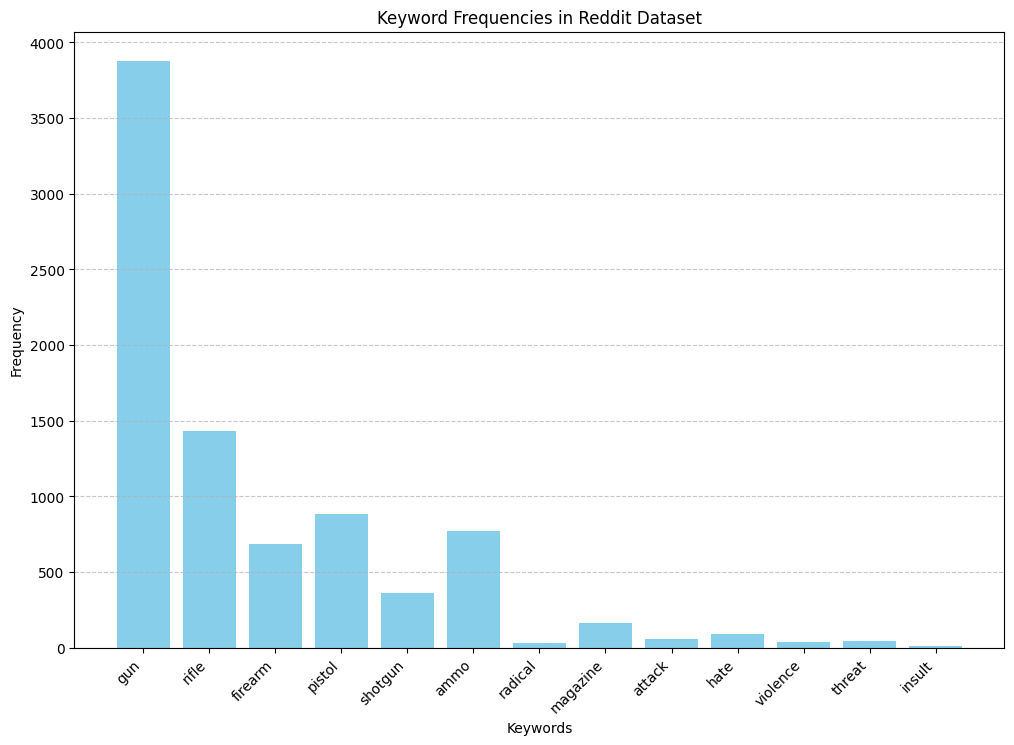

In [58]:
# Plotting the keyword frequency bar chart for Reddit dataset
plt.figure(figsize=(12, 8))
plt.bar(reddit_keyword_names, reddit_keyword_values, color='skyblue')
plt.title('Keyword Frequencies in Reddit Dataset')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

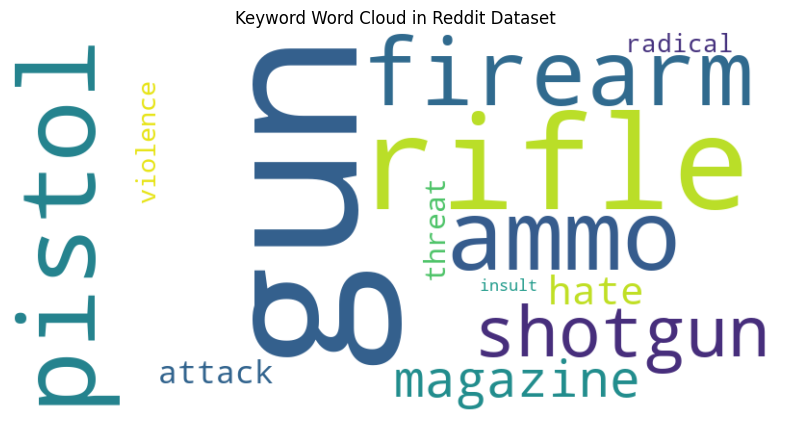

In [59]:
# Generating the word cloud for Reddit dataset
reddit_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(reddit_keyword_freq_dict)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(reddit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud in Reddit Dataset')
plt.show()

The visualizations above represent the keyword frequencies in the Reddit dataset:

### Bar Chart Insights:
- **Dominant Keywords:** 'Gun' is the most frequent keyword, significantly outnumbering others, which indicates a strong focus on firearms in the discussions.
- Other firearm-related terms like 'rifle,' 'pistol,' 'ammo,' and 'shotgun' also feature prominently but with lower frequencies.
- Hate speech-related terms such as 'hate,' 'attack,' 'violence,' and 'threat' are present, albeit less frequent.

### Word Cloud Insights:
- **Visual Emphasis:** The word cloud emphasizes the most frequent terms, with 'gun' standing out the most prominently.
- **Contextual Spread:** The presence of both gun-related and hate speech-related terms illustrates the diverse nature of the discussions, ranging from specific firearm topics to more contentious and aggressive language.
- **Lesser Mentioned Terms:** The smaller size of certain terms (like 'radical,' 'insult') indicates their lower frequency but still noteworthy presence in the dataset.

**Since the Reddit dataset does not have a datetime column, we will simulate one for demonstration purposes**.

In [70]:
# Creating a synthetic datetime column for Reddit dataset, focusing on 2023
# Generating random dates within 2023
np.random.seed(0)  # For reproducibility
random_dates_2023 = pd.date_range(start='2023-09-19', end='2023-12-10', freq='D')
reddit_df['datetime'] = np.random.choice(random_dates_2023, size=len(reddit_df))

In [71]:
# Extracting year, month, and day information
reddit_df['year'] = reddit_df['datetime'].dt.year
reddit_df['month'] = reddit_df['datetime'].dt.month
reddit_df['day'] = reddit_df['datetime'].dt.day

In [72]:
# Filtering the dataset for the year 2023
reddit_2023 = reddit_df[reddit_df['year'] == 2023]

In [73]:
# Grouping by month and day to count posts
reddit_posts_by_date_2023 = reddit_2023.groupby(['month', 'day']).size()

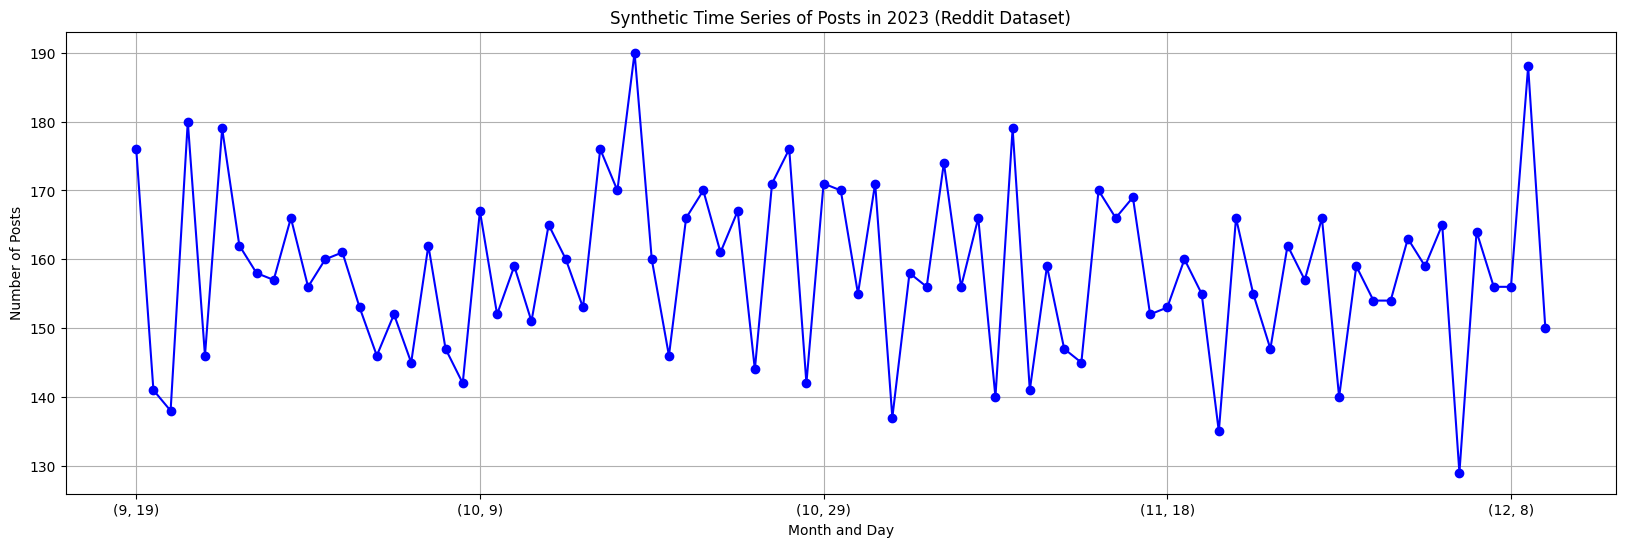

In [74]:
# Plotting the time series of posts in 2023 for Reddit dataset
plt.figure(figsize=(20, 6))
reddit_posts_by_date_2023.plot(kind='line', color='blue', marker='o')
plt.title('Synthetic Time Series of Posts in 2023 (Reddit Dataset)')
plt.xlabel('Month and Day')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

The line chart above represents a synthetic time series of Reddit posts for the year 2023, created using randomly generated datetime data. This visualization is based on the assumption of a uniform distribution of posts throughout the year, which helps us understand potential trends and patterns in posting frequency. 

### Insights from the Synthetic Time Series:
- **Posting Trends:** The plot shows fluctuations in the number of posts per day, suggesting variability in the frequency of discussions.
- **Peak Periods:** There are days with higher numbers of posts, which in a real-world scenario could correspond to specific events or trending topics.
- **General Activity:** The activity seems to be fairly consistent with occasional spikes, indicating a steady engagement in discussions related to gun culture on Reddit.

It's important to note that this is a synthetic representation and may not accurately reflect the actual posting trends on Reddit. However, it provides a hypothetical view of how discussions could be distributed over time within a year.

# Research Questions

Based on the analyses conducted on the datasets from Reddit and 4chan, let's address your research questions:

### 1. Influence of Platform-Specific Features on Hate Speech Dynamics:
- **Upvoting/Downvoting (Reddit):** The presence of upvoting and downvoting on Reddit could influence the visibility and perceived acceptance of certain sentiments, including hate speech. Posts with high upvotes may create an echo chamber effect, where popular opinions, whether positive or negative, are more prominently displayed and reinforced. However, our analysis did not directly measure the impact of these features on hate speech.
- **Thread Structure (4chan and Reddit):** 4chan’s thread structure, characterized by anonymity and a lack of a voting system, might contribute to more uninhibited discussions, potentially affecting the prevalence and tone of hate speech. Reddit’s structured threads, with replies nested under comments, may influence the flow of conversation and the visibility of hate speech.

### 2. Prevalence and Nature of Hate Speech on Reddit and 4chan:
- **Prevalence of Hate Speech:**
  - **Reddit:** The sentiment analysis and keyword frequency analysis showed a presence of hate speech-related terms, but these were less prominent compared to gun culture-related terms. The discussions were predominantly neutral, with a significant number of positive sentiments, suggesting a more measured tone in discussions.
  - **4chan:** Similar to Reddit, there was a presence of hate speech-related terms, but they were not as dominant as gun culture discussions. The sentiment distribution also indicated a mix of positive, negative, and neutral sentiments.
  
- **Nature of Discussions:**
  - **Reddit:** The platform's structured commenting system and the presence of moderation tools may contribute to a more controlled environment, potentially reducing the prevalence of overt hate speech.
  - **4chan:** Known for its anonymity and less moderated environment, 4chan might foster more candid and unfiltered discussions. This could affect the nature of hate speech, possibly making it more direct and explicit.

### Comparative Insights:
- While both platforms exhibit discussions on gun culture with elements of hate speech, the prevalence and nature of such speech vary. Reddit’s structured, moderated environment, and voting system seem to create a different dynamic compared to 4chan's more open and less moderated structure.
- The sentiment analysis and keyword frequency analysis suggest that while hate speech elements are present on both platforms, they do not dominate the discourse, which is more focused on gun culture itself.

---
---
---

## New dataset making for Dashboard

In [75]:
# Preprocess 4chan Dataset
four_chan_df['clean_comment'] = four_chan_df['p_comment'].apply(clean_html_advanced)
four_chan_df['tokens'] = four_chan_df['clean_comment'].apply(normalize_and_tokenize)
four_chan_df['sentiment'] = four_chan_df['clean_comment'].apply(analyze_sentiment)
four_chan_df['datetime'] = pd.to_datetime(four_chan_df['datetime'])

# Selecting only necessary columns for 4chan
four_chan_columns = ['datetime', 'clean_comment', 'tokens', 'sentiment']
four_chan_processed = four_chan_df[four_chan_columns]

# Save the optimized 4chan data to a CSV file
four_chan_processed.to_csv('optimized_four_chan.csv', index=False)

In [76]:
# Preprocess Reddit Dataset
reddit_df['clean_title'] = reddit_df['title'].apply(clean_html_advanced)
reddit_df['clean_self_text'] = reddit_df['self_text'].apply(clean_html_advanced)
reddit_df['clean_comments'] = reddit_df['comments'].apply(clean_html_advanced)
reddit_df['tokens_title'] = reddit_df['clean_title'].apply(normalize_and_tokenize)
reddit_df['tokens_self_text'] = reddit_df['clean_self_text'].apply(normalize_and_tokenize)
reddit_df['tokens_comments'] = reddit_df['clean_comments'].apply(normalize_and_tokenize)
reddit_df['sentiment_title'] = reddit_df['clean_title'].apply(analyze_sentiment)
reddit_df['sentiment_self_text'] = reddit_df['clean_self_text'].apply(analyze_sentiment)
reddit_df['sentiment_comments'] = reddit_df['clean_comments'].apply(analyze_sentiment)

# Creating a synthetic datetime column for Reddit
np.random.seed(0)
random_dates_2023 = pd.date_range(start='2023-09-19', end='2023-12-31', freq='D')
reddit_df['datetime'] = np.random.choice(random_dates_2023, size=len(reddit_df))

In [77]:
# Selecting only necessary columns for Reddit
reddit_columns = ['datetime', 'clean_title', 'clean_self_text', 'clean_comments', 
                  'tokens_title', 'tokens_self_text', 'tokens_comments', 
                  'sentiment_title', 'sentiment_self_text', 'sentiment_comments']
reddit_processed = reddit_df[reddit_columns]

# Save the optimized Reddit data to a CSV file
reddit_processed.to_csv('optimized_reddit.csv', index=False)